In [1081]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [1082]:
def plot_result(data):
    plt.imshow(data)
    plt.show()

(1024, 1024, 3)


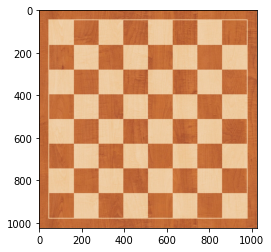

In [1083]:
pipes = np.array(Image.open("chessboard.jpg"))
pipes = pipes / 255
print(pipes.shape)
inputs = np.array([pipes])
pipes = inputs
plot_result(pipes[0])

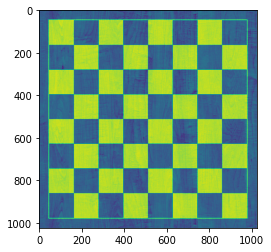

In [1084]:
rgb_to_grey_layer = layers.Conv2D(1, (1, 1), input_shape=pipes.shape, padding='same', use_bias=False,
                                  weights=[np.array([[[[0.4], [0.4], [0.2]]]])], trainable=False)
inputs = rgb_to_grey_layer(inputs)
plot_result(inputs[0])

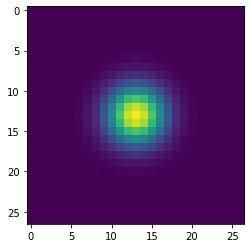

0.9999998904807406


In [1085]:
def gaussian_filter(size, sigma=1):
    k = int((size - 1) / 2)
    prob = [np.exp(-z * z / (2 * sigma * sigma)) / np.sqrt(2 * np.pi * sigma * sigma) for z in range(-k, k + 1)]
    return np.outer(prob, prob)


n = 27
sigma = 2.5
weights = gaussian_filter(n, sigma)
plot_result(weights)
print(np.sum(weights))

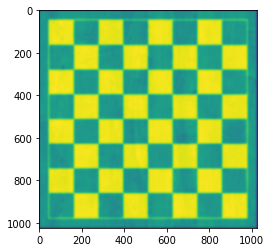

In [1086]:
#blur
n = 27
sigma = 5

blur_layer = layers.Conv2D(1, (n, n), use_bias=False,
                           weights=[gaussian_filter(n, sigma).reshape((n, n, 1, 1))],
                           padding='same', trainable=False)

inputs = blur_layer(inputs)
plot_result(inputs[0])

(1, 1024, 1024, 2)


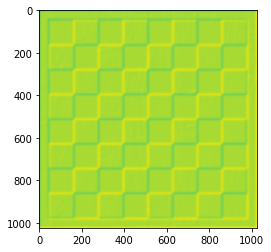

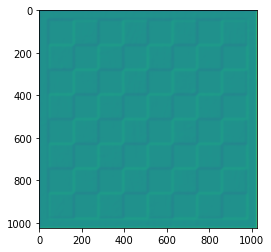

In [1087]:
# sobel
sobel_filters = np.array([[[[1, 2, 1], [0, 0, 0], [-1, -2, -1]], [[1, 0, -1], [2, 0, -2], [1, 0, -1]]]]).reshape(
    (3, 3, 1, 2))

sobel_layer = layers.Conv2D(2, (3, 3), padding='same', use_bias=False, weights=[sobel_filters], trainable=False)

inputs = sobel_layer(inputs)
print(inputs.shape)
plot_result(inputs[0, :, :, 0])
plot_result(inputs[0, :, :, 1])

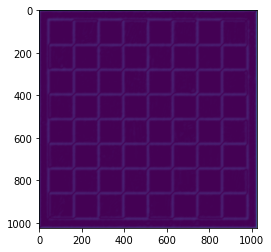

In [1088]:
pow2_layer = layers.Lambda(lambda x: x * x)
sum_layer = layers.Conv2D(1, (1, 1), padding='same', use_bias=False,
                          weights=[np.array([[[[1], [1]]]])], trainable=False)
sqrt_layer = layers.Lambda(lambda x: tf.math.sqrt(x))

inputs = pow2_layer(inputs)
inputs = sum_layer(inputs)
inputs = sqrt_layer(inputs)

plot_result(inputs[0])

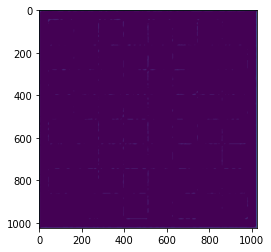

In [1089]:
threshold_layer = layers.ReLU(threshold=0.07, trainable=False)
norm_layer = layers.Lambda(lambda x: x / tf.reduce_max(x))

inputs = threshold_layer(inputs)
inputs = norm_layer(inputs)

plot_result(inputs[0])

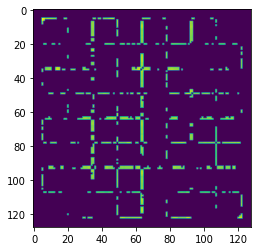

In [1090]:

max_pooling_layer = layers.MaxPool2D(pool_size=(8, 8), padding='same', trainable=False)
fine_tuning = layers.Lambda(lambda t: tf.where(tf.greater(t, tf.constant(0.12)),tf.zeros_like(t),t))
inputs = max_pooling_layer(inputs)
inputs = fine_tuning(inputs)
plot_result(inputs[0])

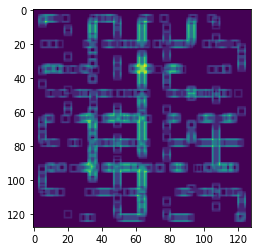

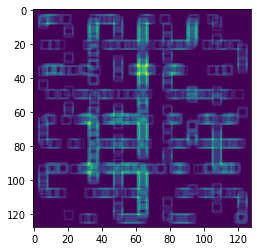

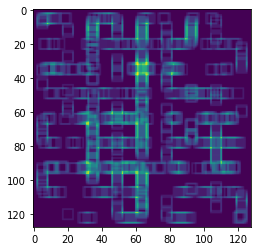

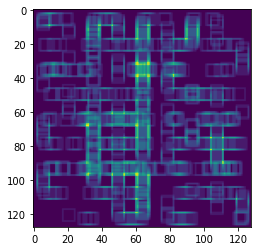

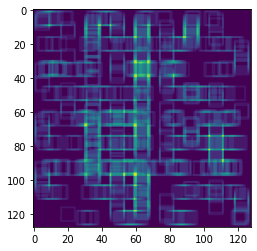

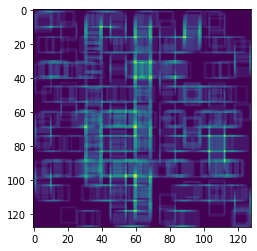

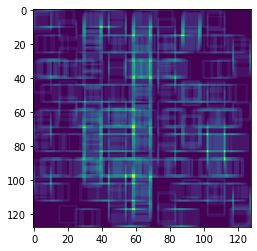

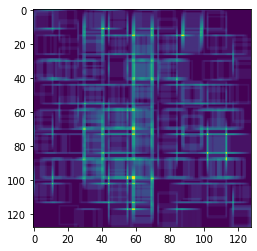

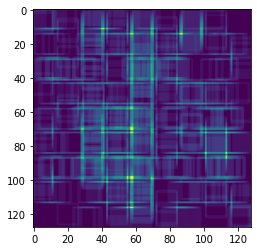

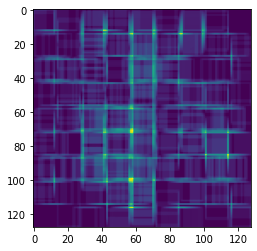

In [1091]:
outputs = []
for x in range(5, 15):
    weights = np.zeros(shape=(x, x, 1, 1))
    weights[0, :] = 1
    weights[-1, :] = 1
    weights[:, 0] = 1
    weights[:, -1] = 1

    output = layers.Conv2DTranspose(1, kernel_size=(x, x), weights=[weights], padding='same',
                                    trainable=False, use_bias=False)(inputs)
    outputs.append(output)
    plot_result(output[0])

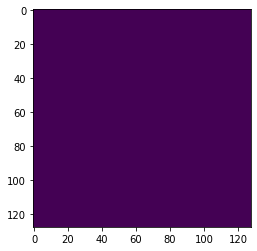

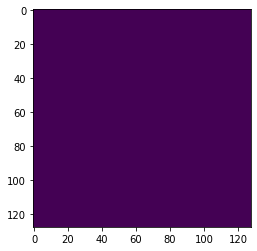

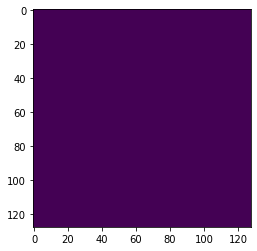

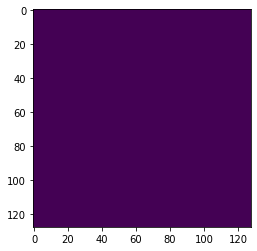

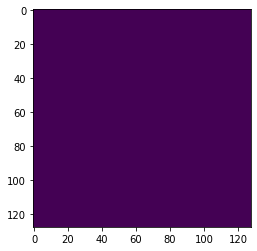

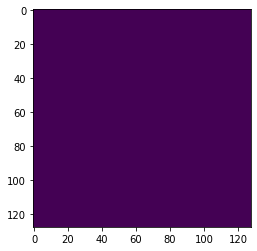

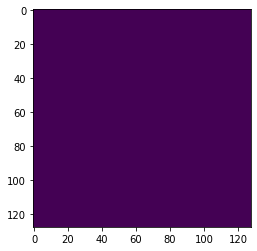

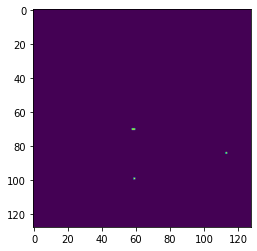

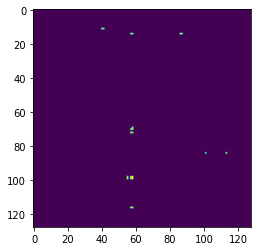

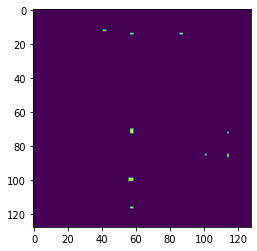

In [1092]:
top_values = np.zeros(shape=(10,100))
for i,_ in enumerate(outputs):
    top_values[i] = tf.nn.top_k(tf.reshape(outputs[i],-1),k=100, sorted=True)[0]

threshold = tf.nn.top_k(top_values.reshape(-1),k=50, sorted=True)[0][-1]

for i,_ in enumerate(outputs):
    output = layers.ReLU(threshold=threshold, trainable=False)(outputs[i])
    plot_result(output[0])
    outputs[i] = output

In [1093]:
for x in range(5, 15):
    weights = np.zeros(shape=(x, x, 1, 1))
    weights[0, :] = 1
    weights[-1, :] = 1
    weights[:, 0] = 1
    weights[:, -1] = 1

    output = layers.Conv2DTranspose(1, kernel_size=(x, x), weights=[weights], padding='same',
                                    trainable=False, use_bias=False)(outputs[x-5])

    # plot_result(output[0])
    outputs[x-5] = output

In [1094]:
for i,_ in enumerate(outputs):
    output = layers.UpSampling2D((8,8))(outputs[i])
    # plot_result(output[0])
    outputs[i] = output



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 1024, 1024, 3)
(1, 1024, 1024, 3)
(1, 1024, 1024, 1)


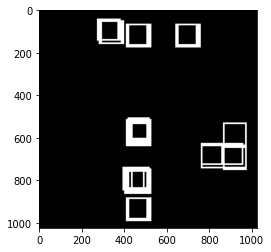

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


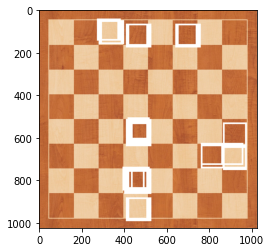

In [1095]:
result = np.zeros(pipes.shape)
print(pipes.shape)
print(result.shape)
print(outputs[0].shape)
for output in outputs:
    result += output
    pipes += output
plot_result(result[0])
plot_result(pipes[0])

